In [1]:
import numpy as np
import matplotlib.pyplot as plt
from NeedALight.magnus import Magnus1, Magnus3_Re, Magnus3_Im
from scipy.special import erfi

We begin by defining the functions inside the integral (i.e. PMF and Pump Envelope) as well as some constants


In [2]:
N = 201
vp = 0.1  # pump velocity, does not change anything for magnus.
l = 1.0  # amplification region length
sig = 1  # pump wave packet spread. This is the only parameter which matters/changes things.
a = 1.61 / 1.13  # from symmetric grp vel matching


def symmetric_v(vp, sig, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sig))
    vs = vp / (1 + 2 * a * vp / (l * sig))
    return vs, vi


vs, vi = symmetric_v(vp, sig, l, a)

kappa = 1 / vs - 1 / vp

# Frequency values
wi = -4
wf = 4
w = np.linspace(wi, wf, N)


# For the pump, we take it ot be L2 normalized
def pump(x):
    return np.exp(-((x) ** 2) / (2 * (sig) ** 2)) / np.power(np.pi * (sig) ** 2, 1 / 4)


# For the Sinc PMF, we assume linear dispersion w=v*k and invert for k.
def PMF(x, y, z):
    return np.sinc(l * (x / vs + y / vi - z / vp) / (2 * np.pi))


# Gaussian PMF, parametrized such that for first Magnus term has same width as pump.
def PMF2(x, y, z):
    return np.exp(-((l * (x / vs + y / vi - z / vp)) ** 2) / (2 * (sig * kappa) ** 2))

We now define the product of the pump and PMF. At this stage one can either take the Sinc or Gaussian PMF

In [220]:
# Product of PMF and Pump Envelope which is to be integrated
F = lambda x, y, z: pump(z) * PMF2(x, y, z)
# Note that  there is no strength factor at this stage. It is added manually at the end.
# You can also add a multiplicative factor if taking sig<0.8 to help with fidelity.

We now consider the first order Magnus term

In [221]:
J1 = Magnus1(F, w)

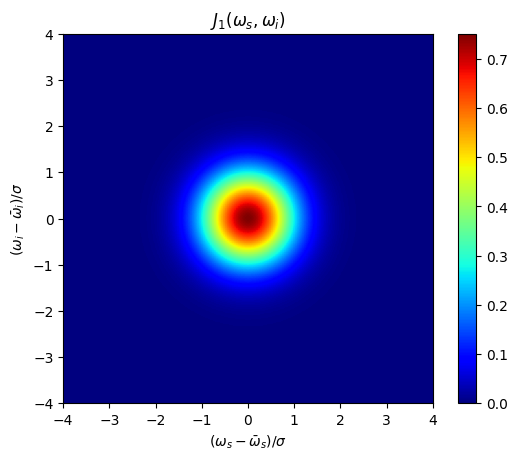

In [222]:
# Generating plot of JSA
fig, ax = plt.subplots()
im = ax.imshow(J1, cmap="jet", origin="lower", extent=[w[0], w[N - 1], w[0], w[N - 1]])
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
ax.set_title(r"$J_{1}(\omega_{s}, \omega_{i})$")
plt.colorbar(im, orientation="vertical")
plt.show()

We now consider the real part of the third order Magnus term (J3)

In [223]:
J3 = Magnus3_Re(F, w)

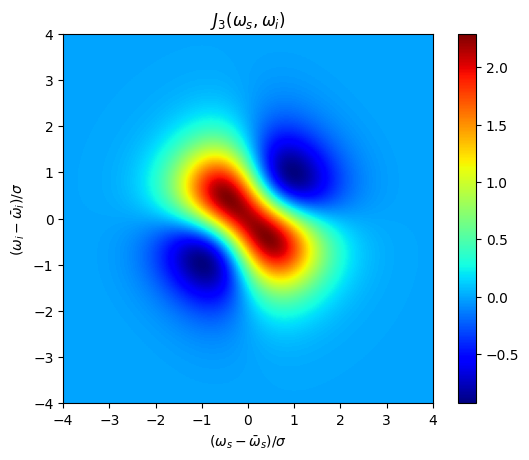

In [224]:
# Generating plot of JSA
fig, ax = plt.subplots()
im = ax.imshow(J3, cmap="jet", origin="lower", extent=[w[0], w[N - 1], w[0], w[N - 1]])
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
ax.set_title(r"$J_{3}(\omega_{s}, \omega_{i})$")
plt.colorbar(im, orientation="vertical")
plt.show()

We now consider the imaginary part of the third order Magnus term (K3)

In [225]:
K3 = Magnus3_Im(F, w)

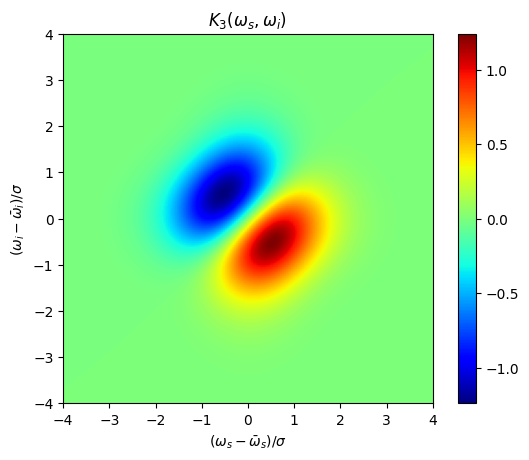

In [226]:
# Generating plot of JSA
fig, ax = plt.subplots()
im = ax.imshow(K3, cmap="jet", origin="lower", extent=[w[0], w[N - 1], w[0], w[N - 1]])
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
ax.set_title(r"$K_{3}(\omega_{s}, \omega_{i})$")
plt.colorbar(im, orientation="vertical")
plt.show()

Combining everything into a corrected JSA

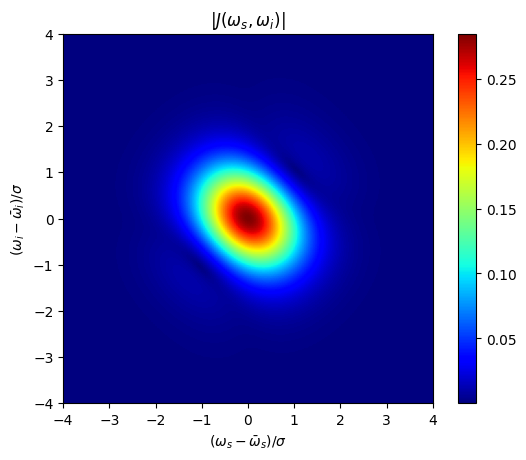

In [227]:
epsilon = 0.3
JSA = epsilon * J1 + epsilon**3 * J3 - 1j * (epsilon**3) * K3

fig, ax = plt.subplots()
im = ax.imshow(
    np.abs(JSA), cmap="jet", origin="lower", extent=[w[0], w[N - 1], w[0], w[N - 1]]
)
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
ax.set_title(r"$| J(\omega_{s}, \omega_{i})|$")
plt.colorbar(im, orientation="vertical")
plt.show()

For the case where both the pump and PMF are Gaussians, we have access to analytical results. We can thus calculate the Fidelity between our Magnus code and analytics. Cubature is itself quite finicky and so depending on the choice of parameters chosen, it might be better to include a multiplicative factor in the definition of "F" above to increase fidelity (e.g. for sig=0.6, an additional factor of 1.5 is needed, otherwise the results are skewed).

In [228]:
# Next we consider analytics.
tau = 1 / (np.sqrt(2) * sig)  # To equate the two different conventions used.


f0 = lambda x: np.sqrt(2 * tau) * np.exp(-2 * tau**2 * (x**2)) / np.power(np.pi, 1 / 4)
f1 = lambda x: np.sqrt(3) * f0(x) * erfi(np.sqrt(4 / 3) * tau * x)


J1_th = f0(w) * f0(w[:, np.newaxis])
J3_th = (f0(w) * f0(w[:, np.newaxis]) - f1(w) * f1(w[:, np.newaxis])) / 12
K3_th = -(f0(w) * f1(w[:, np.newaxis]) - f1(w) * f0(w[:, np.newaxis])) / (
    4 * np.sqrt(3)
)  # Extra minus sign is due to different conventions used

# Normalizing so max value is unity
J1 = J1 / np.amax(J1)
J3 = J3 / np.amax(J3)
K3 = K3 / np.amax(K3)
J1_th = J1_th / np.amax(J1_th)
J3_th = J3_th / np.amax(J3_th)
K3_th = K3_th / np.amax(K3_th)

# Finding Fidelity between theory and Magnus
J1n = J1 / np.linalg.norm(J1)
J1tn = J1_th / np.linalg.norm(J1_th)

J3n = J3 / np.linalg.norm(J3)
J3tn = J3_th / np.linalg.norm(J3_th)

K3n = K3 / np.linalg.norm(K3)
K3tn = K3_th / np.linalg.norm(K3_th)

FidelityJ1 = np.sum(J1n * np.conjugate(J1tn))
FidelityJ3 = np.sum(J3n * np.conjugate(J3tn))
FidelityK3 = np.sum(K3n * np.conjugate(K3tn))
FidelityJ1, FidelityJ3, FidelityK3

(1.000000000000002, 0.9999340031606083, 0.9999514468327708)